### Recommendation System

#### Content-based Filtering


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
from gensim import corpora, models, similarities
import re
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [29]:
STOP_WORD_FILE = 'data/vietnamese-stopwords.txt'

def getStopWords():
    stop_words = []
    with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
        stop_words = file.read()

    stop_words = stop_words.split('\n')
    return stop_words


In [30]:
stop_words = getStopWords()
stop_words

['a_lô',
 'a_ha',
 'ai',
 'ai_ai',
 'ai_nấy',
 'ai_đó',
 'alô',
 'amen',
 'anh',
 'anh_ấy',
 'ba',
 'ba_ba',
 'ba_bản',
 'ba_cùng',
 'ba_họ',
 'ba_ngày',
 'ba_ngôi',
 'ba_tăng',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu',
 'bao_nả',
 'bay_biến',
 'biết',
 'biết_bao',
 'biết_bao_nhiêu',
 'biết_chắc',
 'biết_chừng_nào',
 'biết_mình',
 'biết_mấy',
 'biết_thế',
 'biết_trước',
 'biết_việc',
 'biết_đâu',
 'biết_đâu_chừng',
 'biết_đâu_đấy',
 'biết_được',
 'buổi',
 'buổi_làm',
 'buổi_mới',
 'buổi_ngày',
 'buổi_sớm',
 'bà',
 'bà_ấy',
 'bài',
 'bài_bác',
 'bài_bỏ',
 'bài_cái',
 'bác',
 'bán',
 'bán_cấp',
 'bán_dạ',
 'bán_thế',
 'bây_bẩy',
 'bây_chừ',
 'bây_giờ',
 'bây_nhiêu',
 'bèn',
 'béng',
 'bên',
 'bên_bị',
 'bên_có',
 'bên_cạnh',
 'bông',
 'bước',
 'bước_khỏi',
 'bước_tới',
 'bước_đi',
 'bạn',
 'bản',
 'bản_bộ',
 'bản_riêng',
 'bản_thân',
 'bản_ý',
 'bất_chợt',
 'bất_cứ',
 'bất_giác',
 'bất_kì',
 'bất_kể',
 'bất_kỳ',
 'bất_luận',
 'bất_ngờ',
 'bất_nhược',
 'bất_quá',
 'bất_quá_chỉ',
 'bất_thình_l

In [31]:
df = pd.read_csv("data/items.csv")
df.head()

,product_id,product_name,category,sub_category,image,price,rating,Content_wt
0,190,"Áo ba lỗ thun gân ,form body tôn dáng",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/2c1ca03f5dc42f316fdf...,86250.0,4.9,"Áo lỗ thun gân , form body tôn_dáng Thời_Trang..."
1,191,"Áo Ba Lỗ Nam Trắng Chất Cotton Siêu Mát, Siêu Đẹp",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/c7ea4c6574dc79be6b26...,26800.0,4.9,"Áo Ba_Lỗ Nam_Trắng Chất_Cotton Siêu_Mát , Siêu..."
2,192,"Áo Ba Lỗ Nam Tyasuo chất vải co dãn mát, không...",Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/6f93bcda10efe374f8cc...,39500.0,4.8,"Áo Ba_Lỗ Nam_Tyasuo chất vải co_dãn mát , khôn..."
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,https://cf.shopee.vn/file/1d7ed5e34bff8bc8b49a...,16500.0,4.8,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Thời_Trang...
4,194,Áo Thun Nam Thể Thao Ba Lỗ Mẫu Mới Siêu Đẹp (B...,Thời Trang Nam,Áo Ba Lỗ,NaN,45000.0,4.8,Áo Thun_Nam Thể_Thao Ba_Lỗ Mẫu_Mới Siêu_Đẹp ( ...


* Preprocess text: remove number, remove special characters and convert to lowercase

In [32]:
# Tiền xử lý dữ liệu
def preprocess_text(content):
    # Remove numbers
    content_clean = [[re.sub('[0-9]+','', e) for e in text] for text in content]
    
    # Remove special characters and convert to lowercase
    special_chars = ['', ' ', ',', '.', '...', '-', ':', ';', '?', '%', '(', ')', '+', '/', "'", '&']
    content_clean = [[t.lower() for t in text if not t in special_chars] for text in content_clean]
    
    return content_clean

# Tokenize(split) the sentences into words
content = [[text for text in x.split()] for x in df.Content_wt]
content_re = preprocess_text(content)
content_re[:1]

[['áo',
  'lỗ',
  'thun',
  'gân',
  'form',
  'body',
  'tôn_dáng',
  'thời_trang',
  'nam_áo',
  'ba_lỗ',
  'danh_mục',
  'shopee',
  'thời_trang',
  'nam_áo',
  'ba_lỗ',
  'chiều',
  'tay_áo',
  'khác',
  'phong_cách',
  'thể_cơ_đường',
  'nhiệt_đới',
  'tall_fit',
  'có',
  'xuất_xứ',
  'việt_nam_dáng',
  'kiểu',
  'áo',
  'ôm_sát',
  'chất_liệu',
  'cotton_mẫu',
  'sọc_tăm',
  'gân',
  'nổi',
  'kho',
  'hàng',
  'gửi',
  'bà_rịa',
  'vũng_tàu',
  'best',
  'tank_tops',
  'for_men',
  'áo_ba',
  'lỗ_quốc_dân',
  'cho_nam',
  'bảng_size',
  'size_m',
  'size_l',
  'kg',
  'size_xl',
  'kg',
  'size_xxl',
  'kg',
  'kg',
  'size',
  'chuẩn',
  'mặc',
  'kiểu',
  'body_nha',
  'quý_khách',
  'không',
  'thích',
  'mặc',
  'ôm']]

##### Gensim

* Tạo Dictionary, Corpus

In [33]:
def create_dictionary_and_corpus(content_re):
    # Create dictionary
    dictionary = corpora.Dictionary(content_re)
    feature_cnt = len(dictionary.token2id)
    
    # Create corpus
    corpus = [dictionary.doc2bow(text) for text in content_re]
    
    return dictionary, corpus, feature_cnt

# Usage
dictionary, corpus, feature_cnt = create_dictionary_and_corpus(content_re)

# Print dictionary and corpus information
print(f"Token to ID mappings:")
print(dictionary.token2id)
print(f"\nNumber of features (unique words): {feature_cnt}")
print(f"\nCorpus size (number of documents): {len(corpus)}")
print(f"Sample document vector (token_id, frequency): {corpus[0]}")

Token to ID mappings:
{'ba_lỗ': 0, 'best': 1, 'body': 2, 'body_nha': 3, 'bà_rịa': 4, 'bảng_size': 5, 'chiều': 6, 'cho_nam': 7, 'chuẩn': 8, 'chất_liệu': 9, 'cotton_mẫu': 10, 'có': 11, 'danh_mục': 12, 'for_men': 13, 'form': 14, 'gân': 15, 'gửi': 16, 'hàng': 17, 'kg': 18, 'kho': 19, 'khác': 20, 'không': 21, 'kiểu': 22, 'lỗ': 23, 'lỗ_quốc_dân': 24, 'mặc': 25, 'nam_áo': 26, 'nhiệt_đới': 27, 'nổi': 28, 'phong_cách': 29, 'quý_khách': 30, 'shopee': 31, 'size': 32, 'size_l': 33, 'size_m': 34, 'size_xl': 35, 'size_xxl': 36, 'sọc_tăm': 37, 'tall_fit': 38, 'tank_tops': 39, 'tay_áo': 40, 'thun': 41, 'thích': 42, 'thể_cơ_đường': 43, 'thời_trang': 44, 'tôn_dáng': 45, 'việt_nam_dáng': 46, 'vũng_tàu': 47, 'xuất_xứ': 48, 'áo': 49, 'áo_ba': 50, 'ôm': 51, 'ôm_sát': 52, 'azman_địa_chỉ': 53, 'chất_cotton': 54, 'co_giãn': 55, 'cotton': 56, 'giúp': 57, 'hà_nội': 58, 'hà_đông': 59, 'hôi': 60, 'hút': 61, 'khoắn': 62, 'khó_chịu': 63, 'khỏe': 64, 'lằn': 65, 'mái': 66, 'mềm_thoáng': 67, 'mổ': 68, 'nam_giới': 69, '

* Tạo hàm tính TF-IDF, Similarity Matrix

In [34]:
def create_tfidf_similarity_matrix(corpus, feature_cnt):
    # Create TF-IDF model
    tfidf = models.TfidfModel(corpus)
    
    # Create similarity matrix
    similarity_matrix = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=feature_cnt)
    
    return tfidf, similarity_matrix

# Usage
tfidf, similarity_matrix = create_tfidf_similarity_matrix(corpus, feature_cnt)
print("Similarity matrix Length:", len(similarity_matrix))

Similarity matrix Length: 49653


In [35]:
# Save TF-IDF model and similarity matrix
def save_models(tfidf, similarity_matrix, tfidf_path='models/gensim_tfidf.model', sim_matrix_path='models/gensim_similarity.matrix'):
    # Save TF-IDF model
    tfidf.save(tfidf_path)
    
    # Save similarity matrix
    similarity_matrix.save(sim_matrix_path)
    
    print(f"Models saved to {tfidf_path} and {sim_matrix_path}")

# Load saved models
def load_models(tfidf_path='models/gensim_tfidf.model', sim_matrix_path='models/gensim_similarity.matrix'):
    # Load TF-IDF model
    tfidf = models.TfidfModel.load(tfidf_path)
    
    # Load similarity matrix
    similarity_matrix = similarities.SparseMatrixSimilarity.load(sim_matrix_path)
    
    return tfidf, similarity_matrix

# Usage example:
# Save models
save_models(tfidf, similarity_matrix)

# Load models
tfidf, similarity_matrix = load_models()


Models saved to models/gensim_tfidf.model and models/gensim_similarity.matrix


Similarity Score Statistics:
Average Score: 0.0168
Standard Deviation: 0.0323
Median Score: 0.0074


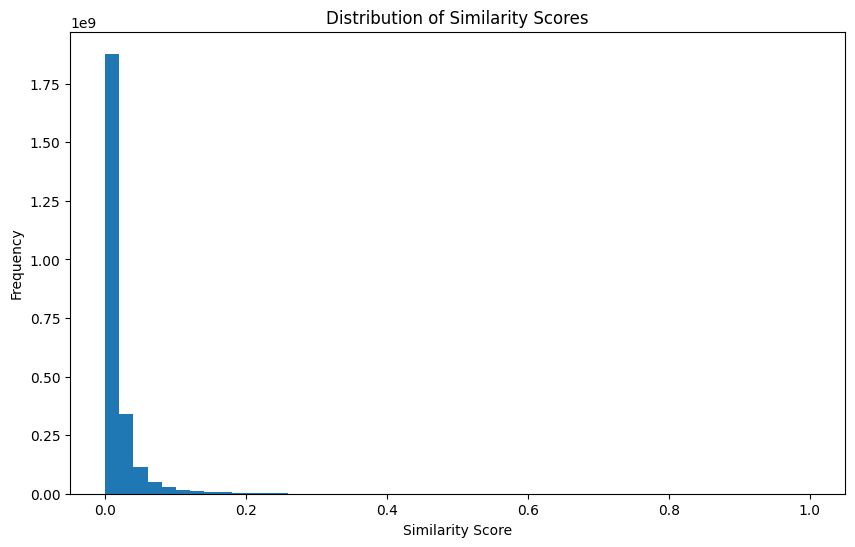

In [36]:
def analyze_similarity_scores(similarity_matrix):
    # Convert similarity matrix to numpy array
    scores = np.array(similarity_matrix)
    scores = scores.flatten()
    
    # Basic statistics
    avg_score = np.mean(scores)
    std_score = np.std(scores)
    median_score = np.median(scores)
    
    return avg_score, std_score, median_score

# Calculate and display similarity score statistics
avg, std, median = analyze_similarity_scores(similarity_matrix)

print("Similarity Score Statistics:")
print(f"Average Score: {avg:.4f}")
print(f"Standard Deviation: {std:.4f}")
print(f"Median Score: {median:.4f}")

# Optional: Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(np.array(similarity_matrix).flatten(), bins=50)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.show()

Phân tích biểu đồ phân phối Similarity Scores:
1. Phần lớn scores tập trung ở 0-0.2 (phân phối lệch phải)
2. Dataset đa dạng, ít sản phẩm trùng lặp
3. Ngưỡng similarity phù hợp cho recommendation ≈ 0.2

* Tạo hàm `get_content_based_recommendations`

In [37]:
def get_similarity_scores(sims, top_k, exclude_idx=None):
    sim_scores = list(enumerate(sims))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    if exclude_idx is not None:
        sim_scores = [s for s in sim_scores if s[0] != exclude_idx]
    
    return sim_scores[:top_k]

def format_recommendations(df, sim_scores):
    product_indices = [i[0] for i in sim_scores]
    recommendations = df.iloc[product_indices][['product_id', 'product_name', 'category', 'sub_category', 'Content_wt']]
    recommendations['similarity_score'] = [i[1] for i in sim_scores]
    return recommendations

def process_keyword_query(query, dictionary, stop_words):
    query = query.lower().strip()
    query_tokens = word_tokenize(query)
    
    query_tokens = [token for token in query_tokens 
                   if token not in stop_words 
                   and len(token) > 1]
    
    if len(query_tokens) == 0:
        raise ValueError("Query too short or contains only stop words")
    
    if len(query_tokens) > 10:
        print("Warning: Long queries may reduce accuracy. Consider using fewer terms.")
    
    query_bow = dictionary.doc2bow(query_tokens)
    if len(query_bow) == 0:
        raise ValueError("No valid keywords found after processing")
        
    return query_bow

def get_content_based_recommendations(query, index, tfidf, corpus, df, dictionary, top_k=5, by_keyword=False):
    if by_keyword:
        query_bow = process_keyword_query(query, dictionary, stop_words)
        sims = index[tfidf[query_bow]]
        sim_scores = get_similarity_scores(sims, top_k)
    else:
        product_idx = df[df['product_id'] == query].index[0]
        doc_vector = corpus[product_idx]
        sims = index[tfidf[doc_vector]]
        sim_scores = get_similarity_scores(sims, top_k, exclude_idx=product_idx)
    
    return format_recommendations(df, sim_scores)

* Lấy Recommendation cho product_id

In [38]:
# Example usage for product ID:
id_search = 19656

recommendations_by_id = get_content_based_recommendations(
    query=id_search,
    index=similarity_matrix,
    tfidf=tfidf,
    corpus=corpus,
    df=df,
    dictionary=dictionary,
    top_k=5,
    by_keyword=False
)
# For product ID based recommendations
print(f"Recommendations based on Product ID {id_search}:")
print("\nOriginal product:")
print(df[df['product_id'] == id_search][df.columns].iloc[0])
print("\nRecommended products:")
recommendations_by_id

Recommendations based on Product ID 19656:

Original product:
product_id                                                  19656
product_name    (A393) DỆT KIM ĐÔNG XUÂN ÁO MAY Ô NAM 3 LỖ MÀU...
category                                           Thời Trang Nam
sub_category                                             Áo Ba Lỗ
image                                                         NaN
price                                                     72000.0
rating                                                        5.0
Content_wt      ( A393 ) DỆT_KIM_ĐÔNG XUÂN_ÁO MAY_Ô_NAM 3 LỖ M...
Name: 1156, dtype: object

Recommended products:


,product_id,product_name,category,sub_category,Content_wt,similarity_score
126,19126,Áo Ba Lỗ Nam 100% Cotton Mặc nhà Thoáng Mát,Thời Trang Nam,Áo Ba Lỗ,Áo Ba_Lỗ Nam 100 % Cotton Mặc Thoáng_Mát Thời_...,0.264407
56,1956,[Xả Kho]Áo Ba Lỗ Nam 100% Cotton Mặc nhà Thoán...,Thời Trang Nam,Áo Ba Lỗ,[ Xả Kho ]_Áo Ba_Lỗ Nam 100 % Cotton Mặc Thoán...,0.258865
661,191461,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Thời_Trang...,0.256237
3,193,ÁO BA LỖ HÀNG VIỆT NAM 100% COTTON,Thời Trang Nam,Áo Ba Lỗ,ÁO BA_LỖ HÀNG_VIỆT_NAM 100 % COTTON Thời_Trang...,0.254660
804,19304,"Áo ba lỗ, áo ba lỗ nam cao cấp - Hàng Việt nam...",Thời Trang Nam,Áo Ba Lỗ,"Áo lỗ , áo lỗ nam cao_cấp - Hàng Việt_nam chất...",0.246844



1. **Độ liên quan về mặt nội dung:**
- Tất cả các sản phẩm được gợi ý đều là áo ba lỗ nam, cùng category và sub-category với sản phẩm gốc
- Các sản phẩm đều có đặc điểm tương tự: làm từ cotton, hàng Việt Nam
- Đây là điểm tốt vì cho thấy mô hình đã nắm bắt được đặc trưng chính của sản phẩm

2. **Điểm similarity score:**
- Các scores dao động từ 0.246 đến 0.264
- Mức độ tương đồng này khá thấp (thang điểm từ 0-1)
- Tuy nhiên với bài toán recommendation và dữ liệu tiếng Việt, mức này có thể chấp nhận được


* Lấy recommendation cho keyword


**Invalid Keywords Examples**:

```python
   keyword_search = "á"
   keyword_search = "và ai bà anh ba"
   # Result: ValueError: Query too short or contains only stop words
```

```python
   keyword_search = "áo ba lỗ nam cao cấp - Hàng Việt nam chất lượng cao 100% cotton, mặc mát vào mùa hè, ấm vào mùa đông"
   # Result: Warning: Long queries may reduce accuracy. Consider using fewer terms.
```

**Valid Keywords Examples**:
```python
   # Basic search
   keyword_search = "áo"

   # Optimal length
   keyword_search = "áo thun nam cotton"

   # Maximum recommended length
   keyword_search = "áo thun nam cotton giá rẻ chất lượng tốt nhất việt nam"
```


In [39]:

# Example usage for keyword search:
keyword_search = "áo thun nam cotton"

recommendations_by_keyword = get_content_based_recommendations(
    query=keyword_search,
    index=similarity_matrix,
    tfidf=tfidf,
    corpus=corpus,
    df=df,
    dictionary=dictionary,
    top_k=5,
    by_keyword=True
)

# For keyword based recommendations
print("Recommendations for keyword:", keyword_search)
recommendations_by_keyword

Recommendations for keyword: áo thun nam cotton


,product_id,product_name,category,sub_category,Content_wt,similarity_score
18452,241323,Sét bộ thun gồm 2 áo 1 quần 115k,Thời Trang Nam,Đồ Hóa Trang,Sét thun 2 áo 1 quần 115 k Thời_Trang Nam_Đồ H...,0.380703
188,19188,[SALE] 99k Áo thun nam 3 lỗ- áo thun nam tank ...,Thời Trang Nam,Áo Ba Lỗ,[ SALE_] 99 k Áo thun nam 3 lỗ - áo thun nam t...,0.356474
6059,1875,Áo Thun polo Nam KINSMAN Tay Ngắn Thêu Gấu có ...,Thời Trang Nam,Áo,Áo Thun polo_Nam KINSMAN_Tay Ngắn Thêu_Gấu cổ ...,0.343634
17256,234922,Bộ Quần áo thể thao cotton thun lạnh phối kẻ nam,Thời Trang Nam,Đồ Bộ,Bộ Quần_áo thể_thao cotton thun lạnh_phối kẻ n...,0.342139
17325,234991,Đồ đôi nam nữ váy thun kết hợp cùng áo thun na...,Thời Trang Nam,Đồ Bộ,Đồ đôi nam_nữ váy thun kết_hợp áo thun nam thê...,0.341745


1. **Độ liên quan về mặt nội dung:**
- Các sản phẩm được gợi ý khá đa dạng về sub-category (Đồ Hóa Trang, Áo Ba Lỗ, Áo, Đồ Bộ) không tập trung vào áo thun như từ khóa tìm kiếm
- Chỉ có 2/5 sản phẩm thực sự liên quan đến áo thun nam (sản phẩm 2 và 3)
- Mô hình đang focus quá nhiều vào từ "thun" trong các ngữ cảnh khác (váy thun, thun lạnh, bộ thun)
- Đây là điểm yếu cần cải thiện vì chưa nắm bắt được ngữ cảnh chính xác của từ khóa tìm kiếm

2. **Điểm similarity score:**
- Các scores dao động từ 0.341 đến 0.380
- Mức độ tương đồng này cao hơn so với gensim (>0.3)
- Tuy nhiên điểm số cao nhất lại thuộc về sản phẩm không liên quan (bộ đồ)
- Cho thấy việc tính similarity score đang chưa phản ánh đúng ngữ nghĩa của sản phẩm